In [1]:
import os
import wandb
import copy 
import json
import pickle 

import pandas as pd 
print(pd.__version__)
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import analyse_results_utils
from es_map import custom_configs
from es_map.my_brax_envs import brax_envs

1.4.2


In [2]:
with open('env_result_data_v3.pickle', 'rb') as handle:
    env_result_data = pickle.load(handle)
with open('ES_grouped_runs.pickle', 'rb') as handle:
    ES_grouped_runs = pickle.load(handle)

In [3]:
# Ok let us go over each metric
# Collect the relevant data from the 2 sets of data
# create the plots and the tables

In [27]:
# METRICS

# Best fitness
env_result_data["ant"]["NO_BOTH_ME__explore-exploit"]

[{'best_ever_eval_distance_walked': array(37.43524, dtype=float32),
  'best_ever_child_mean_distance_walked': array(32.698483, dtype=float32),
  'best_ever_child_distance_walked': array(45.320595, dtype=float32),
  'evolver_ed_var_score': 1011.1922798156738,
  'evolver_ed_ent_score': 138.73422516699455,
  'perf_qd_mean_dist': 3676.2017,
  'perf_nonempty_ratio': 0.177734375,
  'max_lineage_length': 37,
  'mean_lineage_length': 23.956,
  'evo_ent': 7.844715912889096,
  'evo_var': 90.48981475830078},
 {'best_ever_eval_distance_walked': array(37.97847, dtype=float32),
  'best_ever_child_mean_distance_walked': array(34.37991, dtype=float32),
  'best_ever_child_distance_walked': array(47.299046, dtype=float32),
  'evolver_ed_var_score': 1616.229507446289,
  'evolver_ed_ent_score': 185.9273807051194,
  'perf_qd_mean_dist': 4869.007,
  'perf_nonempty_ratio': 0.2216796875,
  'max_lineage_length': 61,
  'mean_lineage_length': 44.898,
  'evo_ent': 7.910286267034375,
  'evo_var': 117.2751007080078

In [3]:
def collect_metric(metric_name_data):
    
    # We want to collect the data in the following format:
    # {env_name : {algo_name : [run1_metric,run2_metric]}}
    
    comnined_data = {
    "ant" : {},
    "humanoid" : {}
    }
    
    # now order them with a custom order:
    algo_order = {
        'ES' : 'ES',
        'E-ES' : 'E-ES',
        'QE-ES' : 'QE-ES',
        'QDE-ES' : 'QDE-ES',
        "NO_BOTH_ME__exploit" : "ME_exploit",
        "NO_BOTH_ME__explore-exploit" : "ME_explore_exploit",
        "NO_EVOLVABILITY_SELECTION_EVAL_FITNESS" : "ME_no_selection_eval",
        "NO_EVOLVABILITY_SELECTION" : "ME_no_selection",
        "NO_EVOLVABILITY_UPDATE_MM" : "ME-MM_exploit",
        "NO_EVOLVABILITY_UPDATE_ND" : "ME-ND_exploit",
        "NO_EVOLVABILITY_UPDATE_NO_INNOV_MM" : "ME-MM_explore_exploit",
        "NO_EVOLVABILITY_UPDATE_NO_INNOV_ND" : "ME-ND_explore_exploit",
        "FULL_MM" : "ME-MM_full",
        "FULL_ND" : "ME-ND_full",
    }
    def sort_key(item):
            return list(algo_order.values()).index(item[0])
        
    for env_name in ["ant","humanoid"]:
        if metric_name_data["ES_NAME"] is not None:
            for algo_name,runs in ES_grouped_runs[env_name].items():
                algo_plot_name = algo_order[algo_name]
                comnined_data[env_name][algo_plot_name] = [run[metric_name_data["ES_NAME"]] for run in runs]
        for algo_name,runs in env_result_data[env_name].items():
            algo_plot_name = algo_order[algo_name]
            comnined_data[env_name][algo_plot_name] = [run[metric_name_data["MAP_NAME"]] for run in runs]
    
        
            
            
        
        comnined_data[env_name] = dict(sorted(comnined_data[env_name].items(), key=sort_key))
        comnined_data[env_name] = {algo_name : np.array(results) for algo_name,results in comnined_data[env_name].items()}
    
    return comnined_data

def plot_bolxplots(metric_name_data,combined_data):
    
    save_path = "/home/userfs/a/ak1774/workspace/evolvability_map_elites/figs/"
    
    for env_name,env_data in combined_data.items():
        names = list(env_data.keys())
        values = list(env_data.values())

        sns.boxplot(data=values,color="white",saturation=0)#,whis=(0,100))
        sns.stripplot(data=values)#,color="black")
        plt.xticks(list(range(len(names))),names,rotation = 90)
        plt.ylabel(metric_name_data["METRIC_PLOT_NAME"])
        plt.title(env_name+" "+metric_name_data["METRIC_PLOT_NAME"])
        #plt.ylim(bottom=0)

        plt.savefig(save_path+metric_name_data["METRIC_PLOT_NAME"]+"_"+env_name+".png",bbox_inches = "tight")
        plt.show()
        
    for env_name,env_data in combined_data.items():
        names = list(env_data.keys())
        values = list(env_data.values())

        sns.boxplot(data=values,color="white",saturation=0)#,whis=(0,100))
        sns.stripplot(data=values)#,color="black")
        plt.xticks(list(range(len(names))),names,rotation = 90)
        plt.ylabel(metric_name_data["METRIC_PLOT_NAME"])
        plt.title(env_name+" "+metric_name_data["METRIC_PLOT_NAME"])
        plt.ylim(bottom=0)

        plt.savefig(save_path+metric_name_data["METRIC_PLOT_NAME"]+"_"+env_name+"_lim0"+".png",bbox_inches = "tight")
        plt.show()
        
def create_table(combined_data,precise=False):
    columns = {}
    for env_name,env_data in combined_data.items():

        result_column = []
        for algo_names,results in env_data.items():
            mean = np.mean(results)
            std = np.std(results)
            if precise is False:
                result_column.append("{:10.1f}".format(mean)+u"\u00B1"+"{:10.1f}".format(std))
            else:
                result_column.append("{:10.3f}".format(mean)+u"\u00B1"+"{:10.3f}".format(std))
        columns["algo_name"] = list(env_data.keys())
        columns[env_name] = result_column

    df = pd.DataFrame()
    for col_name,values in columns.items():
        df[col_name] = values

        
    df = df.style.highlight_max(subset=["ant","humanoid"],color = 'lightgreen', axis = 0)
    return df

In [73]:
# THE IMPORTNATN METRICS
# eval_fitness
# diversity (ES not included)
# evolvability (entropy)
# QD (ES not included)
# ED (ES not included)

In [53]:
all_table = {}
all_combined_data = {}

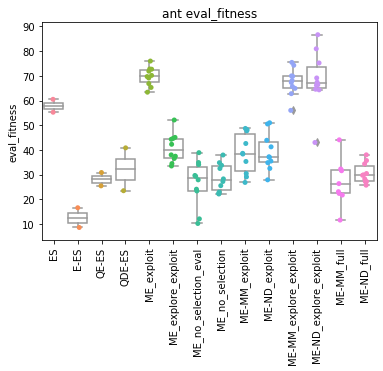

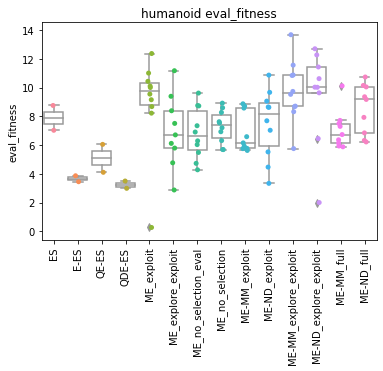

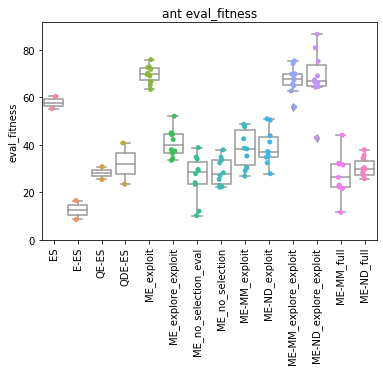

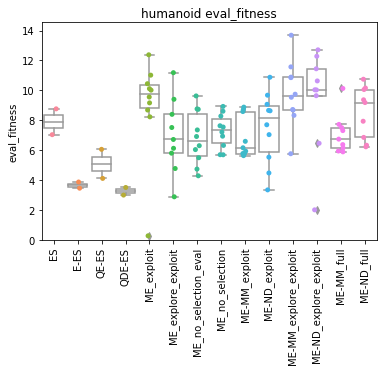

,algo_name,ant,humanoid
0,ES,57.9± 2.6,7.9± 0.9
1,E-ES,12.6± 4.0,3.7± 0.2
2,QE-ES,28.1± 2.7,5.1± 1.0
3,QDE-ES,32.1± 8.7,3.2± 0.3
4,ME_exploit,69.8± 3.6,9.0± 3.1
5,ME_explore_exploit,40.8± 5.5,7.0± 2.3
6,ME_no_selection_eval,26.4± 8.9,6.8± 1.7
7,ME_no_selection,28.7± 5.4,7.3± 1.1
8,ME-MM_exploit,38.6± 7.8,6.9± 1.3
9,ME-ND_exploit,39.1± 7.1,7.5± 2.3


In [54]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "eval_fitness",
    "ES_NAME" : "best_eval_fitness",
    "MAP_NAME" : "best_ever_eval_distance_walked",
}
combined_data = collect_metric(metric_name_data)
plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
all_table[metric_name_data["METRIC_PLOT_NAME"]] = df.data
all_combined_data[metric_name_data["METRIC_PLOT_NAME"]] = combined_data
df

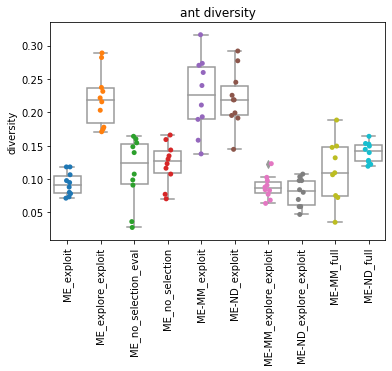

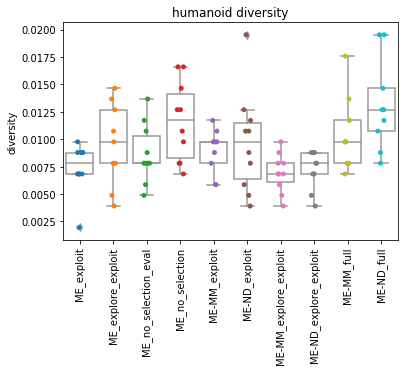

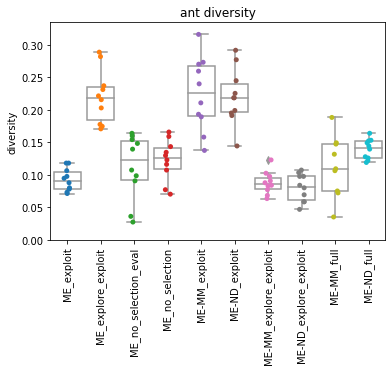

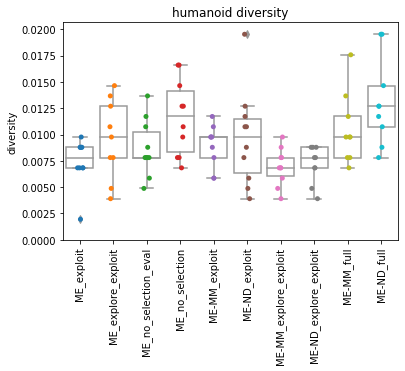

,algo_name,ant,humanoid
0,ME_exploit,0.093± 0.017,0.007± 0.002
1,ME_explore_exploit,0.220± 0.040,0.010± 0.004
2,ME_no_selection_eval,0.113± 0.047,0.009± 0.003
3,ME_no_selection,0.123± 0.030,0.012± 0.003
4,ME-MM_exploit,0.225± 0.054,0.009± 0.002
5,ME-ND_exploit,0.221± 0.041,0.010± 0.004
6,ME-MM_explore_exploit,0.088± 0.016,0.007± 0.002
7,ME-ND_explore_exploit,0.080± 0.020,0.007± 0.002
8,ME-MM_full,0.113± 0.044,0.011± 0.003
9,ME-ND_full,0.140± 0.015,0.013± 0.004


In [55]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "diversity",
    "ES_NAME" : None,
    "MAP_NAME" : "perf_nonempty_ratio",
}
combined_data = collect_metric(metric_name_data)
plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data,precise=True)
#df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
all_table[metric_name_data["METRIC_PLOT_NAME"]] = df.data
all_combined_data[metric_name_data["METRIC_PLOT_NAME"]] = combined_data
df

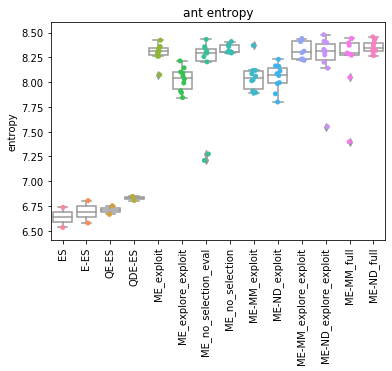

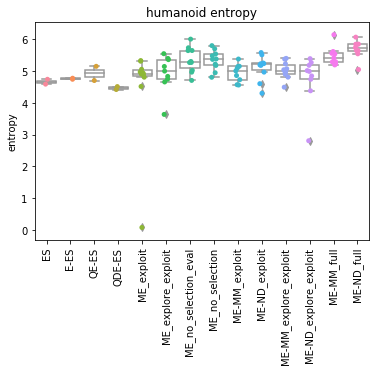

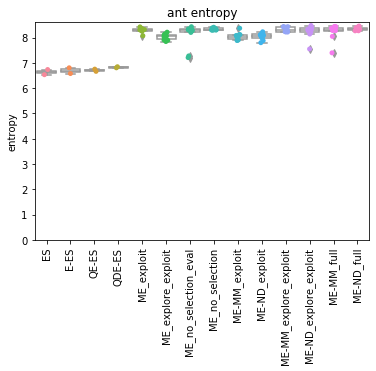

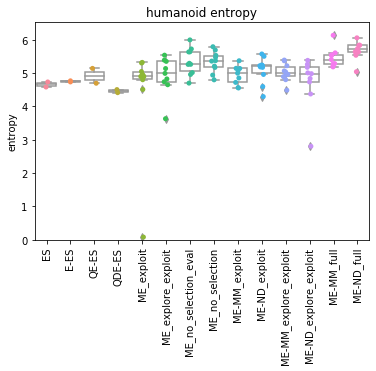

,algo_name,ant,humanoid
0,ES,6.6± 0.1,4.7± 0.1
1,E-ES,6.7± 0.1,4.8± 0.0
2,QE-ES,6.7± 0.0,4.9± 0.2
3,QDE-ES,6.8± 0.0,4.5± 0.0
4,ME_exploit,8.3± 0.1,4.5± 1.5
5,ME_explore_exploit,8.0± 0.1,4.9± 0.5
6,ME_no_selection_eval,8.1± 0.4,5.3± 0.4
7,ME_no_selection,8.3± 0.0,5.3± 0.3
8,ME-MM_exploit,8.0± 0.1,4.9± 0.3
9,ME-ND_exploit,8.0± 0.1,5.1± 0.4


In [56]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "entropy",
    "ES_NAME" : "best_evo_ent",
    "MAP_NAME" : "evo_ent",
}
combined_data = collect_metric(metric_name_data)
plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
all_table[metric_name_data["METRIC_PLOT_NAME"]] = df.data
all_combined_data[metric_name_data["METRIC_PLOT_NAME"]] = combined_data
df

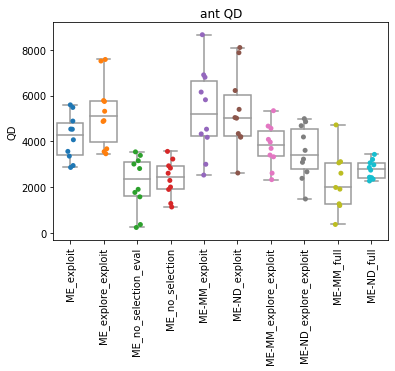

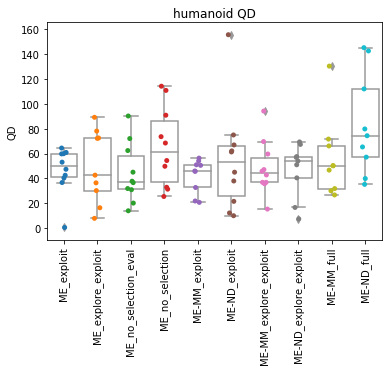

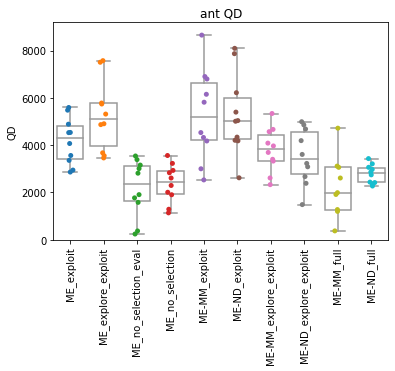

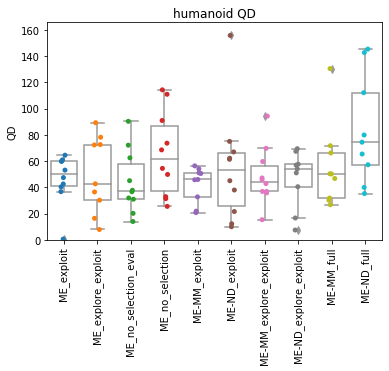

,algo_name,ant,humanoid
0,ME_exploit,4183.0± 935.8,46.6± 17.9
1,ME_explore_exploit,5237.9± 1408.3,49.5± 27.6
2,ME_no_selection_eval,2180.0± 1139.0,44.1± 22.7
3,ME_no_selection,2381.5± 760.6,65.2± 30.6
4,ME-MM_exploit,5288.7± 1810.5,42.1± 12.8
5,ME-ND_exploit,5298.0± 1610.6,54.8± 40.2
6,ME-MM_explore_exploit,3800.2± 881.9,48.4± 20.6
7,ME-ND_explore_exploit,3519.8± 1103.3,46.8± 20.3
8,ME-MM_full,2252.7± 1218.7,56.0± 30.1
9,ME-ND_full,2777.9± 377.5,83.5± 38.7


In [57]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "QD",
    "ES_NAME" : None,
    "MAP_NAME" : "perf_qd_mean_dist",
}
combined_data = collect_metric(metric_name_data)
plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
all_table[metric_name_data["METRIC_PLOT_NAME"]] = df.data
all_combined_data[metric_name_data["METRIC_PLOT_NAME"]] = combined_data
df

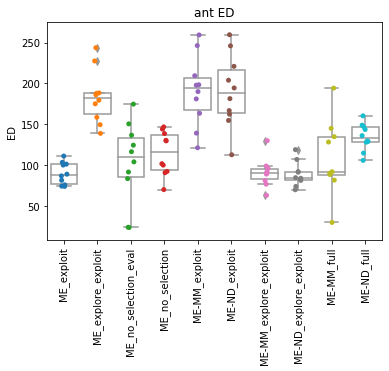

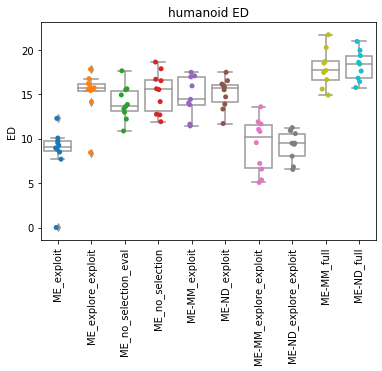

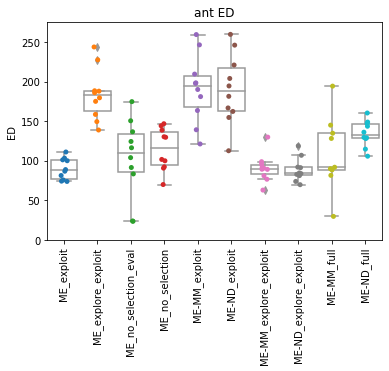

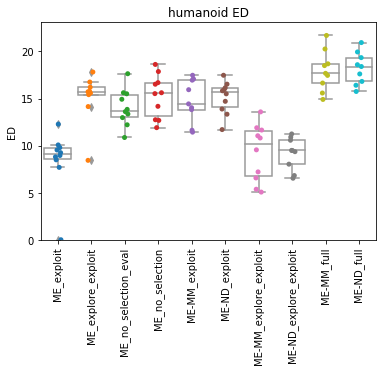

,algo_name,ant,humanoid
0,ME_exploit,89.5± 12.8,8.5± 3.1
1,ME_explore_exploit,183.4± 30.8,15.1± 2.5
2,ME_no_selection_eval,102.8± 47.2,14.1± 1.8
3,ME_no_selection,114.3± 25.3,15.2± 2.2
4,ME-MM_exploit,190.5± 40.8,14.7± 2.1
5,ME-ND_exploit,190.2± 42.2,15.1± 1.6
6,ME-MM_explore_exploit,90.4± 16.4,9.3± 2.8
7,ME-ND_explore_exploit,88.4± 14.0,9.2± 1.6
8,ME-MM_full,109.2± 44.4,17.9± 2.0
9,ME-ND_full,134.2± 15.6,18.2± 1.6


In [58]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "ED",
    "ES_NAME" : None,
    "MAP_NAME" : "evolver_ed_ent_score",
}
combined_data = collect_metric(metric_name_data)
plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
all_table[metric_name_data["METRIC_PLOT_NAME"]] = df.data
all_combined_data[metric_name_data["METRIC_PLOT_NAME"]] = combined_data
df

In [ ]:
# TESTS

In [83]:
# eval test
env_names = ["ant","humanoid"]

eval_better = []
significant = []
for metric,metric_data in all_combined_data.items():
    for env_name in env_names:
        
        no_eval_runs = metric_data[env_name]["ME_no_selection"]
        eval_runs = metric_data[env_name]["ME_no_selection_eval"]
        
        #print(np.mean(no_eval_runs),np.mean(eval_runs))
        
        from scipy.stats import mannwhitneyu
        pnorm = mannwhitneyu(no_eval_runs,eval_runs)

        print(np.mean(no_eval_runs),np.mean(eval_runs))
        eval_better.append(np.mean(no_eval_runs)>np.mean(eval_runs))
        significant.append(pnorm.pvalue < 0.05)
        
eval_better = np.array(eval_better)
significant = np.array(significant)

print("eval_better ",np.sum(eval_better==True)," significant ",np.sum(significant[eval_better==True]))
print("no_eval_better ",np.sum(eval_better==False)," significant ",np.sum(significant[eval_better==False]))


28.733908 26.427109
7.280046 6.819768
0.12275390625 0.1126953125
0.01162109375 0.00869140625
8.334713173217768 8.098984738271119
5.333631974819933 5.348554912564539
2381.4722 2180.0095
65.19895 44.102623
114.28612183525176 102.76151780475945
15.231404255365367 14.051987468896538
eval_better  9  significant  1
no_eval_better  1  significant  0


In [77]:
# ND MM test

algo_names = [
    ["ME-MM_full","ME-ND_full"],
    ["ME-MM_explore_exploit","ME-ND_explore_exploit"],
    ["ME-MM_exploit","ME-ND_exploit"],
]

MM_larger = []
significant = []

for metric,metric_data in all_combined_data.items():
    for env_name in env_names:
        for algo_name_pair in algo_names:
            MM_algo,ND_algo = algo_name_pair
            MM_data = metric_data[env_name][MM_algo]
            ND_data = metric_data[env_name][ND_algo]
            pnorm = mannwhitneyu(MM_data,ND_data)
            
            MM_larger.append(np.mean(MM_data) > np.mean(ND_data))
            significant.append(pnorm.pvalue < 0.05)
            
MM_larger = np.array(MM_larger)
significant = np.array(significant)
print("MM: ",np.sum(MM_larger==True)," significant: ",np.sum(significant[MM_larger==True]==True))
print("ND: ",np.sum(MM_larger==False)," significant: ",np.sum(significant[MM_larger==False]==True))


MM:  10  significant:  0
ND:  20  significant:  3


In [94]:
# evo group test

evo_groups = {
    "full" : ["ME-MM_full","ME-ND_full",],
    "only_selection" : ["ME-MM_exploit","ME-ND_exploit","ME-MM_explore_exploit","ME-ND_explore_exploit",],
    "only_update" : ["ME_no_selection","ME_no_selection_eval",],
    "none" : ["ME_exploit","ME_explore_exploit"],
}

group_results = {}
for metric,metric_data in all_combined_data.items():
    for env_name in env_names:
        group_results[(metric,env_name)] = {}
        for group_name,evo_group in evo_groups.items():
            group_means = {}
            for algo in evo_group:
                data = metric_data[env_name][algo]
                group_means[algo] = np.mean(data)
            group_max_algo = max(group_means, key=group_means.get)
            group_max = group_means[group_max_algo]
            group_results[(metric,env_name)][group_name] = group_max
group_results

for task_tuple,group_result_dict in group_results.items():
    task_max_group = max(group_result_dict, key=group_result_dict.get)
    print(task_tuple,task_max_group)
    
for task_tuple,group_result_dict in group_results.items():
    sorted_groups = [k for k,v in sorted(group_result_dict.items(), key=lambda item: item[1],reverse=True)]
    
    print(task_tuple,sorted_groups)



('eval_fitness', 'ant') none
('eval_fitness', 'humanoid') only_selection
('diversity', 'ant') only_selection
('diversity', 'humanoid') full
('entropy', 'ant') full
('entropy', 'humanoid') full
('QD', 'ant') only_selection
('QD', 'humanoid') full
('ED', 'ant') only_selection
('ED', 'humanoid') full
('eval_fitness', 'ant') ['none', 'only_selection', 'full', 'only_update']
('eval_fitness', 'humanoid') ['only_selection', 'none', 'full', 'only_update']
('diversity', 'ant') ['only_selection', 'none', 'full', 'only_update']
('diversity', 'humanoid') ['full', 'only_update', 'only_selection', 'none']
('entropy', 'ant') ['full', 'only_update', 'only_selection', 'none']
('entropy', 'humanoid') ['full', 'only_update', 'only_selection', 'none']
('QD', 'ant') ['only_selection', 'none', 'full', 'only_update']
('QD', 'humanoid') ['full', 'only_update', 'only_selection', 'none']
('ED', 'ant') ['only_selection', 'none', 'full', 'only_update']
('ED', 'humanoid') ['full', 'only_update', 'only_selection', 

In [85]:
all_combined_data["eval_fitness"]["ant"].keys()

dict_keys(['ES', 'E-ES', 'QE-ES', 'QDE-ES', 'ME_exploit', 'ME_explore_exploit', 'ME_no_selection_eval', 'ME_no_selection', 'ME-MM_exploit', 'ME-ND_exploit', 'ME-MM_explore_exploit', 'ME-ND_explore_exploit', 'ME-MM_full', 'ME-ND_full'])

In [99]:
# create table
group_results

all_task_tuples = list(group_results.keys())
all_task_names = [metric_name +", "+env_name for metric_name,env_name in all_task_tuples]
results_by_group_name = {}
for group_name in evo_groups.keys():
    vals = [group_result_dict[group_name] for task_tuple,group_result_dict in group_results.items()]
    results_by_group_name[group_name] = vals
results_by_group_name

df = pd.DataFrame()
df["task_name"] = all_task_names
for group_name,vals in results_by_group_name.items():
    df[group_name] = vals

#df.to_csv("evo_groups_results"+".csv")
df

,task_name,full,only_selection,only_update,none
0,"eval_fitness, ant",30.631535,68.378952,28.733908,69.782013
1,"eval_fitness, humanoid",8.535167,9.773062,7.280046,8.983256
2,"diversity, ant",0.139844,0.225000,0.122754,0.220410
3,"diversity, humanoid",0.013129,0.009668,0.011621,0.009549
4,"entropy, ant",8.352397,8.322255,8.334713,8.299606
5,"entropy, humanoid",5.682136,5.097994,5.348555,4.917310
6,"QD, ant",2777.876465,5297.976074,2381.472168,5237.946777
7,"QD, humanoid",83.525826,54.776726,65.198952,49.509705
8,"ED, ant",134.178238,190.544125,114.286122,183.400912
9,"ED, humanoid",18.197765,15.100770,15.231404,15.090165


In [104]:
df_evo_or_not = pd.DataFrame()
df_evo_or_not["task_name"] = all_task_names
df_evo_or_not["none"] = df["none"]
df_evo_or_not["any_evo"] = df[["only_selection", "only_update","full"]].max(axis=1)
df_evo_or_not.to_csv("evo_groups_evo_or_not"+".csv")
df_evo_or_not

,task_name,none,any_evo
0,"eval_fitness, ant",69.782013,68.378952
1,"eval_fitness, humanoid",8.983256,9.773062
2,"diversity, ant",0.220410,0.225000
3,"diversity, humanoid",0.009549,0.013129
4,"entropy, ant",8.299606,8.352397
5,"entropy, humanoid",4.917310,5.682136
6,"QD, ant",5237.946777,5297.976074
7,"QD, humanoid",49.509705,83.525826
8,"ED, ant",183.400912,190.544125
9,"ED, humanoid",15.090165,18.197765


0      68.378952
1       9.773062
2       0.225000
3       0.013129
4       8.352397
5       5.682136
6    5297.976074
7      83.525826
8     190.544125
9      18.197765
dtype: float64

In [ ]:
###########################
## SCRATCH ################
###########################

In [37]:
# FIRST METRIC: Best fitness
# For map elites we have 
# - best_ever_eval_distance_walked
# - best_ever_child_mean_distance_walked  # Dont care about this one
# - best_ever_child_distance_walked

# For ES we have 
# - best_eval_fitness
# - best_fitness

metric_name_data = {
    "METRIC_PLOT_NAME" : "best_fitness",
    "ES_NAME" : "best_fitness",
    "MAP_NAME" : "best_ever_child_distance_walked",
}
combined_data = collect_metric(metric_name_data)
#plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["MAP_NAME"]+".csv")
#df

In [38]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "eval_fitness",
    "ES_NAME" : "best_eval_fitness",
    "MAP_NAME" : "best_ever_eval_distance_walked",
}
combined_data = collect_metric(metric_name_data)
#plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["MAP_NAME"]+".csv")
#df

In [39]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "entropy",
    "ES_NAME" : "best_evo_ent",
    "MAP_NAME" : "evo_ent",
}
combined_data = collect_metric(metric_name_data)
#plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["MAP_NAME"]+".csv")
#df

In [40]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "entropy",
    "ES_NAME" : "best_evo_var",
    "MAP_NAME" : "evo_var",
}
combined_data = collect_metric(metric_name_data)
#plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
#df

In [41]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "QD",
    "ES_NAME" : "QD_CUMM",
    "MAP_NAME" : "perf_qd_mean_dist",
}
combined_data = collect_metric(metric_name_data)
#plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
#df

In [42]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "QD",
    "ES_NAME" : "QD",
    "MAP_NAME" : "perf_qd_mean_dist",
}
combined_data = collect_metric(metric_name_data)
#plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
#df

In [43]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "ED",
    "ES_NAME" : None,
    "MAP_NAME" : "evolver_ed_ent_score",
}
combined_data = collect_metric(metric_name_data)
#plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
#df

In [44]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "diversity",
    "ES_NAME" : None,
    "MAP_NAME" : "perf_nonempty_ratio",
}
combined_data = collect_metric(metric_name_data)
#plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data,precise=True)
#df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
#df

In [ ]:
{'best_ever_eval_distance_walked': array(37.43524, dtype=float32),
  'best_ever_child_mean_distance_walked': array(32.698483, dtype=float32),
  'best_ever_child_distance_walked': array(45.320595, dtype=float32),
  'evolver_ed_var_score': 1011.1922798156738,
  'evolver_ed_ent_score': 138.73422516699455,
  'perf_qd_mean_dist': 3676.2017,
  'perf_nonempty_ratio': 0.177734375,
  'max_lineage_length': 37,
  'mean_lineage_length': 23.956,
  'evo_ent': 7.844715912889096,
  'evo_var': 90.48981475830078},

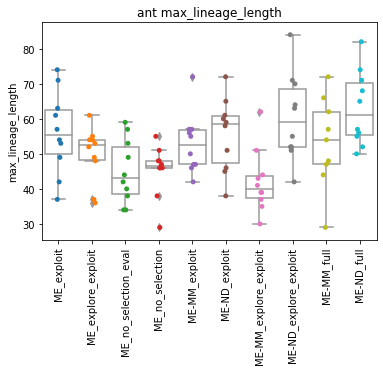

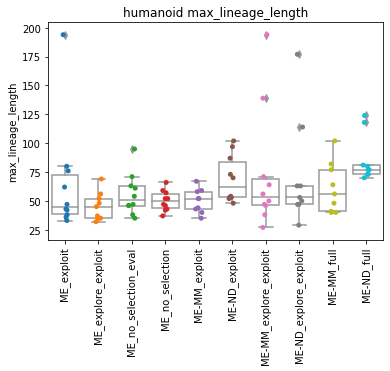

,algo_name,ant,humanoid
0,ME_exploit,56.1± 11.1,65.1± 45.7
1,ME_explore_exploit,49.9± 7.5,45.4± 11.5
2,ME_no_selection_eval,45.0± 8.6,55.6± 16.9
3,ME_no_selection,45.4± 6.8,50.1± 8.4
4,ME-MM_exploit,52.9± 8.1,50.0± 9.7
5,ME-ND_exploit,55.5± 9.8,68.9± 19.2
6,ME-MM_explore_exploit,42.1± 8.5,73.2± 49.6
7,ME-ND_explore_exploit,60.4± 11.7,71.4± 43.3
8,ME-MM_full,53.2± 12.2,61.1± 20.7
9,ME-ND_full,63.0± 10.1,85.9± 19.1


In [28]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "max_lineage_length",
    "ES_NAME" : None,
    "MAP_NAME" : "max_lineage_length",
}
combined_data = collect_metric(metric_name_data)
plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
df

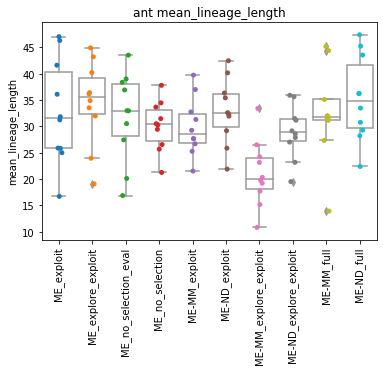

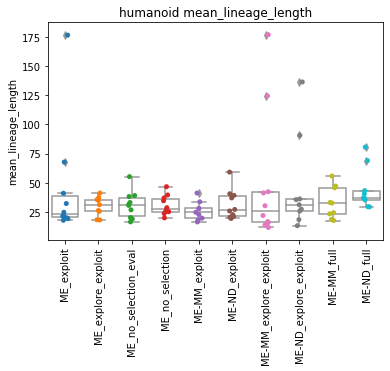

,algo_name,ant,humanoid
0,ME_exploit,32.8± 9.4,44.2± 46.4
1,ME_explore_exploit,34.4± 7.6,29.8± 7.8
2,ME_no_selection_eval,31.9± 8.0,31.0± 10.9
3,ME_no_selection,30.1± 4.5,30.7± 7.9
4,ME-MM_exploit,29.9± 5.2,25.8± 7.5
5,ME-ND_exploit,32.8± 5.9,31.2± 12.0
6,ME-MM_explore_exploit,21.0± 5.9,49.5± 52.9
7,ME-ND_explore_exploit,29.0± 4.8,46.0± 38.3
8,ME-MM_full,32.5± 8.7,33.1± 12.9
9,ME-ND_full,35.3± 7.7,44.5± 16.9


In [29]:
metric_name_data = {
    "METRIC_PLOT_NAME" : "mean_lineage_length",
    "ES_NAME" : None,
    "MAP_NAME" : "mean_lineage_length",
}
combined_data = collect_metric(metric_name_data)
plot_bolxplots(metric_name_data,combined_data)

df = create_table(combined_data)
#df.data.to_csv(metric_name_data["METRIC_PLOT_NAME"]+".csv")
df

In [29]:
env_result_data["ant"].keys()

dict_keys(['NO_EVOLVABILITY_SELECTION_EVAL_FITNESS', 'NO_EVOLVABILITY_SELECTION', 'NO_EVOLVABILITY_UPDATE_ND', 'NO_EVOLVABILITY_UPDATE_NO_INNOV_MM', 'NO_EVOLVABILITY_UPDATE_NO_INNOV_ND', 'NO_EVOLVABILITY_UPDATE_MM', 'FULL_ND', 'FULL_MM', 'NO_BOTH_ME__explore-exploit', 'NO_BOTH_ME__exploit'])

In [12]:
ES_grouped_runs["ant"].keys()

dict_keys(['QDE-ES', 'QE-ES', 'E-ES', 'ES'])

In [8]:
env_result_data["ant"]["NO_EVOLVABILITY_SELECTION_EVAL_FITNESS"][0]

{'best_ever_eval_distance_walked': array(23.358067, dtype=float32),
 'best_ever_child_mean_distance_walked': array(21.563671, dtype=float32),
 'best_ever_child_distance_walked': array(33.12736, dtype=float32),
 'evolver_ed_ent_score': 83.2664571400585,
 'perf_qd_mean_dist': 1582.2871,
 'evo_ent': 8.31421297391241,
 'evo_var': 211.9371795654297}

In [10]:
ES_grouped_runs["ant"]["QDE-ES"]

[{'best_eval_fitness': 23.456655502319336,
  'best_fitness': 38.32007598876953,
  'best_evo_ent': 6.805555840806088,
  'best_evo_var': 161.58978271484375,
  'QD': 2972.449951171875,
  'QD_CUMM': 8738.6962890625},
 {'best_eval_fitness': 40.8178596496582,
  'best_fitness': 55.04482650756836,
  'best_evo_ent': 6.84735553527403,
  'best_evo_var': 223.10458374023438,
  'QD': 6551.0390625,
  'QD_CUMM': 18316.44921875}]